# **Multi-Modal Models with RAG**

In [1]:
import getpass
import os
import openai

# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

True

In [2]:
# To make this work on local machine need to fund an Open API account (minimum is $5)
# See this for OPENAI key info: https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

# To set up openai api key use this if running from Google Colab
#os.environ["OPENAI_API_KEY"] = getpass.getpass()

# If running from local machine use this
openai.api_key = os.environ["OPENAI_API"]

## **Introduction**


In many documents, valuable information is captured in both text and images. Traditional Retrieval-Augmented Generation (RAG) systems often overlook the rich data encapsulated in images, leading to incomplete retrieval and synthesis processes. The emergence of multimodal Large Language Models (LLMs), like GPT-4V, offers an opportunity to enhance RAG systems by effectively incorporating images into the retrieval and generation workflow.

### **Goal**
To create a robust Multi-modal RAG system that integrates text and image data for comprehensive information retrieval and synthesis.

## **Different Ways to Implement Multi-modal RAG System**

Many documents contain a mixture of content types, including text and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:`

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis

`Option 2:`

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

`Option 3`

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   


## **What is the Scope of this Notebook?**

---

This coding notebook highlights `Option 3`.

* We will use [Unstructured](https://unstructured.io/) to parse text, and tables from documents (PDFs).

- We will upload image files, which have been extracted using an ocr tool, which is not the scope of this session, since the focus is on multimodal RAG here.

* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text and images along with their summaries for retrieval.
* We will use GPT-4V for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).

---

- **Packages**

  In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [3]:
!pip install langchain-openai
! pip install -U langchain-community
! pip install -U langchain-chroma
!pip install pypdf
! pip install pillow pydantic lxml pillow matplotlib chromadb tiktoken
!pip install chronological

## **Data Loading**
  
Let's look at a [popular blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) by Jamin Ball.

This is a great use-case because much of the information is captured in images (of tables or charts).
---

For our use case, we will upload the pdf file & images separately to focus better on the Multimodal RAG part. As mentioned earlier, in a real world use case, we will have to use any licensed or open source OCR tool, could be pytessearct etc., to extract the images from pdf files & then proceed with the Multimodal RAG part.

In [4]:
from langchain_community.document_loaders import PyPDFLoader

# Ensure that the dataset is present at the specified path

# If using google colab, do the following:
#from google.colab import drive
#drive.mount('/content/drive')
#DATASET_DIR = "/content/drive/MyDrive/IK/text_to_image_2"

# If running locally, set HOME dir for your machine
DATASET_DIR = "./datasets/RAG demo"

In [5]:
# Load data
loader = PyPDFLoader(f"{DATASET_DIR}/cj.pdf")

docs = loader.load()
tables = [] # Ignore w/ basic pdf loader
texts = [d.page_content for d in docs]

In [6]:
for i in texts:
  print(i,"\n")

11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball
https://cloudedjudgement.substack.com/p/clouded-judgement-111023 1/21
Clouded Judgement 11.10.23 - OpenAI
Updates + Datadog Gives the All-Clear?
JAMIN BALL
NOV 10, 2023
2 Share
Every week I’ll provide updates on the latest trends in cloud so ware companies. Follow along to
stay up to date!
OpenAI Updates
OpenAI had their big developer day this week, and I wanted to call out two key announcements
(and trends): increasing context windows and decreasing costs.
When I think about the monetization of AI (and which “layers” monetize  rst) I’ve always
thought it would follow the below order, with each layer lagging the one that comes before it.
1. Raw silicon (chips like Nvidia bought in large quantities to build out infra to service
upcoming demand).
2. Model providers (OpenAI, Anthropic, etc as companies start building out AI).
35
Type your email... Subscribe 

11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball
https://c

In [7]:
len(texts)

21

## **Multi-vector retriever**

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### **Text and Table summaries**

We will use GPT-4 to produce text summaries.


Summaries are used to retrieve raw tables and / or raw chunks of text.

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

True

In [9]:
from openai import OpenAI
os.environ['OPENAI_API_KEY']=openai.api_key
client = OpenAI() 

client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt="Say this is a test",
  max_tokens=7,
  temperature=0
)


Completion(id='cmpl-C53F00dLU9kiNE3vl4V84fMIKN1iO', choices=[CompletionChoice(finish_reason='stop', index=0, logprobs=None, text='\n\nThis is a test.')], created=1755320134, model='gpt-3.5-turbo-instruct:20230824-v2', object='text_completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=6, prompt_tokens=5, total_tokens=11, completion_tokens_details=None, prompt_tokens_details=None))

In [10]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    # Please add the OpenAI API Key to run this
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts, tables, summarize_texts=True
)

In [11]:
for i in text_summaries:
  print(i,"\n")

The text is a blog post titled "Clouded Judgement 11.10.23" by Jamin Ball, published on November 10, 2023. The post provides weekly updates on trends in cloud software companies, with a focus on OpenAI. The author discusses two key announcements from OpenAI's developer day: increasing context windows and decreasing costs. The author also shares his thoughts on the monetization of AI, suggesting it would follow a certain order starting with raw silicon and followed by model providers. 

The text discusses the monetization of different layers in the tech industry, with a focus on the use of AI and large language models. It highlights the challenges of using AI in production, including data security, compliance, and cost. The author notes that while AI can improve product margins, the high cost of large language models can negate these benefits. Companies are experimenting with building AI functionality and are experiencing 'sticker shock' when faced with the costs. The text suggests that

In [12]:
len(text_summaries)

21

### **Image summaries**

We will use [GPT-4V](https://openai.com/research/gpt-4v-system-card) to produce the image summaries.

The API docs [here](https://platform.openai.com/docs/guides/vision):

* We pass base64 encoded images

In [13]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

fpath = DATASET_DIR
fname = "cj.pdf"

def image_summarize(img_base64, prompt):
    # Please add the OpenAI API Key to run this
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        print(img_file)
        if img_file.endswith(".jpeg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

.DS_Store
cj.pdf
figure-10-1.jpeg
figure-16-1.jpeg
figure-5-1.jpeg
figure-6-1.jpeg
figure-7-1.jpeg


In [14]:
image_summaries

['Line graph depicting EV/NTM Revenue Multiples from Jan 2015 to Oct 2023, comparing high, mid, and low growth medians. Features significant peaks around 2021, with high growth reaching about 45x, mid growth about 20x, and low growth about 11x. Notable decline post-peak with current values at 11.8x for high, 7.4x for mid, and 3.9x for low growth medians. Graph by Altimeter.',
 'Scatter plot titled "NTM Rev Growth vs NTM Rev Multiple" showing various companies represented as dots. The x-axis denotes "NTM Rev Growth" ranging from -5% to 35%, and the y-axis shows "NTM Rev Multiple" from 0x to 18x. A trendline is present with the equation \\(y = 29.462x + 1.5138\\) and \\(R^2 = 0.3821\\). Labeled companies include MDB, NOW, SNOW, and CRWD. The graph includes data points scattered across, illustrating a positive correlation. The chart is credited to Altimeter and @jaminball.',
 'Table comparing company revenues: actual vs. consensus with percentage differences highlighted. Includes next qua

### **Add to vectorstore**

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore`.
* Store the texts, table summaries, and image summaries in the `vectorstore` for efficient semantic retrieval.

In [15]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
# Please add the OpenAI API Key to run this
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings(openai_api_key='')
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## **RAG**

### **Build retriever**

We need to bin the retrieved doc(s) into the correct parts of the GPT-4V prompt template.

In [16]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpeg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    # Please add the OpenAI API Key to run this
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### **Check**

Examine retrieval; we get back images that are relevant to our question.

In [17]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# Separate results by type 
output = split_image_text_types(docs)
print([f"{k}:{len(output[k])}" for k in output.keys()])

['images:2', 'texts:2']



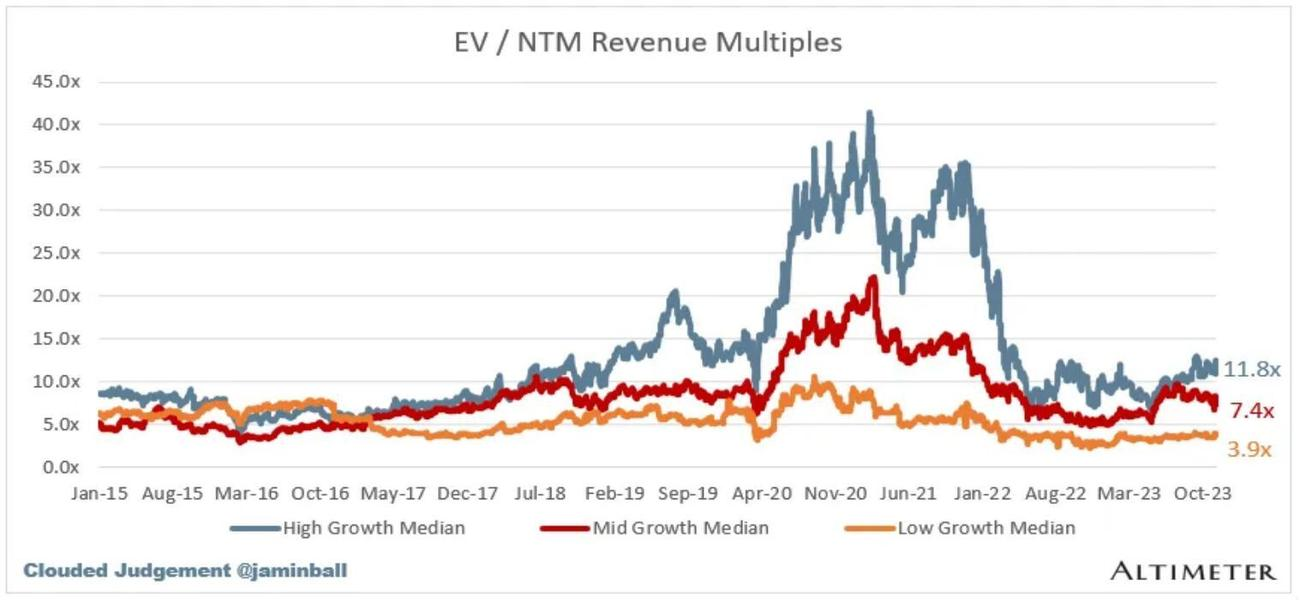


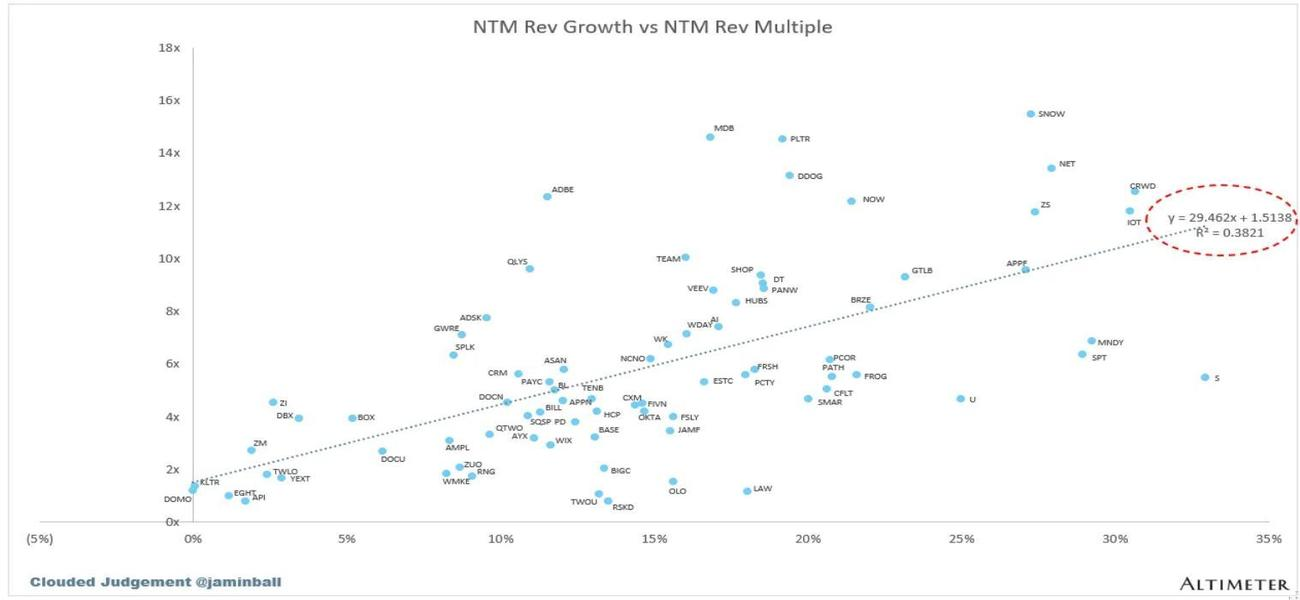

11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball
https://cloudedjudgement.substack.com/p/clouded-judgement-111023 11/21
EV / NTM Rev / NTM Growth
The below chart shows the EV / NTM revenue multiple divided by NTM consensus growth
expectations. So a company trading at 20x NTM revenue that is projected to grow 100% would be
trading at 0.2x. The goal of this graph is to show how relatively cheap / expensive each stock is
relative to their growth expectations 

11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball
https://cloudedjudgement.substack.com/p/clouded-judgement-111023 15/21
Scatter Plot of EV / NTM Rev Multiple vs NTM Rev Growth
How correlated is growth to valuation multiple? 



In [18]:
# Now display both the texts and the images
for img in output['images']:
    plt_img_base64(img)

for txt in output['texts']:
    print(txt,"\n")

In [19]:
# Check retrieval
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# Separate results by type 
output = split_image_text_types(docs)
print([f"{k}:{len(output[k])}" for k in output.keys()])

['images:3', 'texts:1']



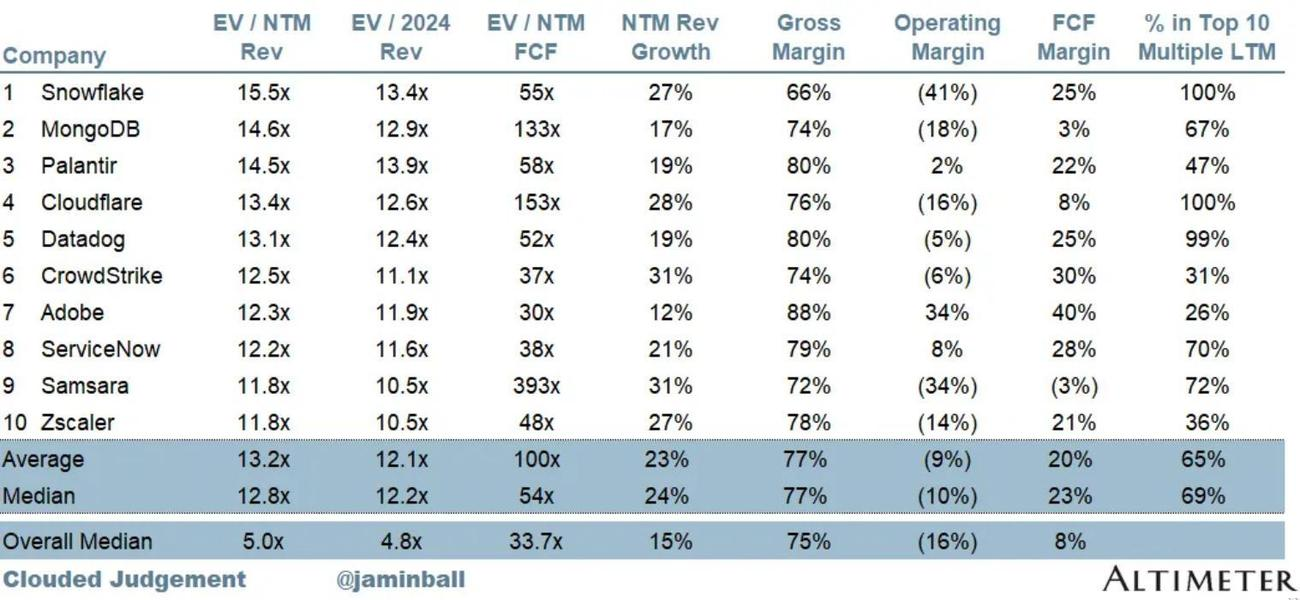


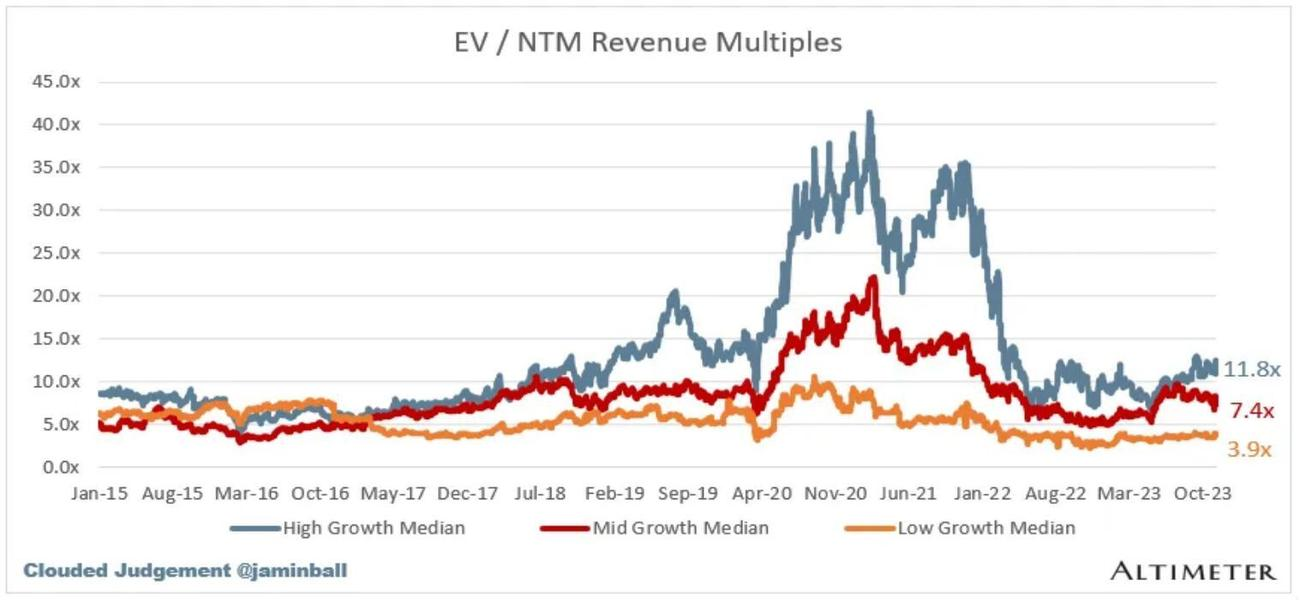


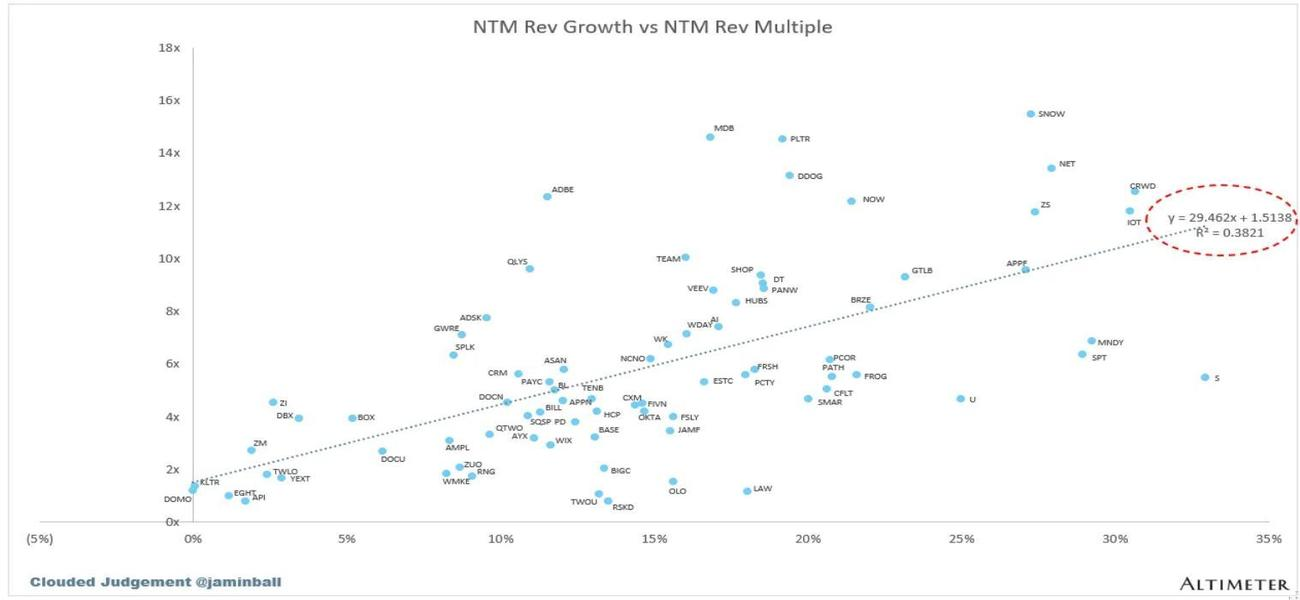

11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball
https://cloudedjudgement.substack.com/p/clouded-judgement-111023 15/21
Scatter Plot of EV / NTM Rev Multiple vs NTM Rev Growth
How correlated is growth to valuation multiple? 



In [20]:
# Now display both the texts and the images
for img in output['images']:
    plt_img_base64(img)

for txt in output['texts']:
    print(txt,"\n")

### **Sanity Check**

Why does this work? Let's look back at the image that we stored ...


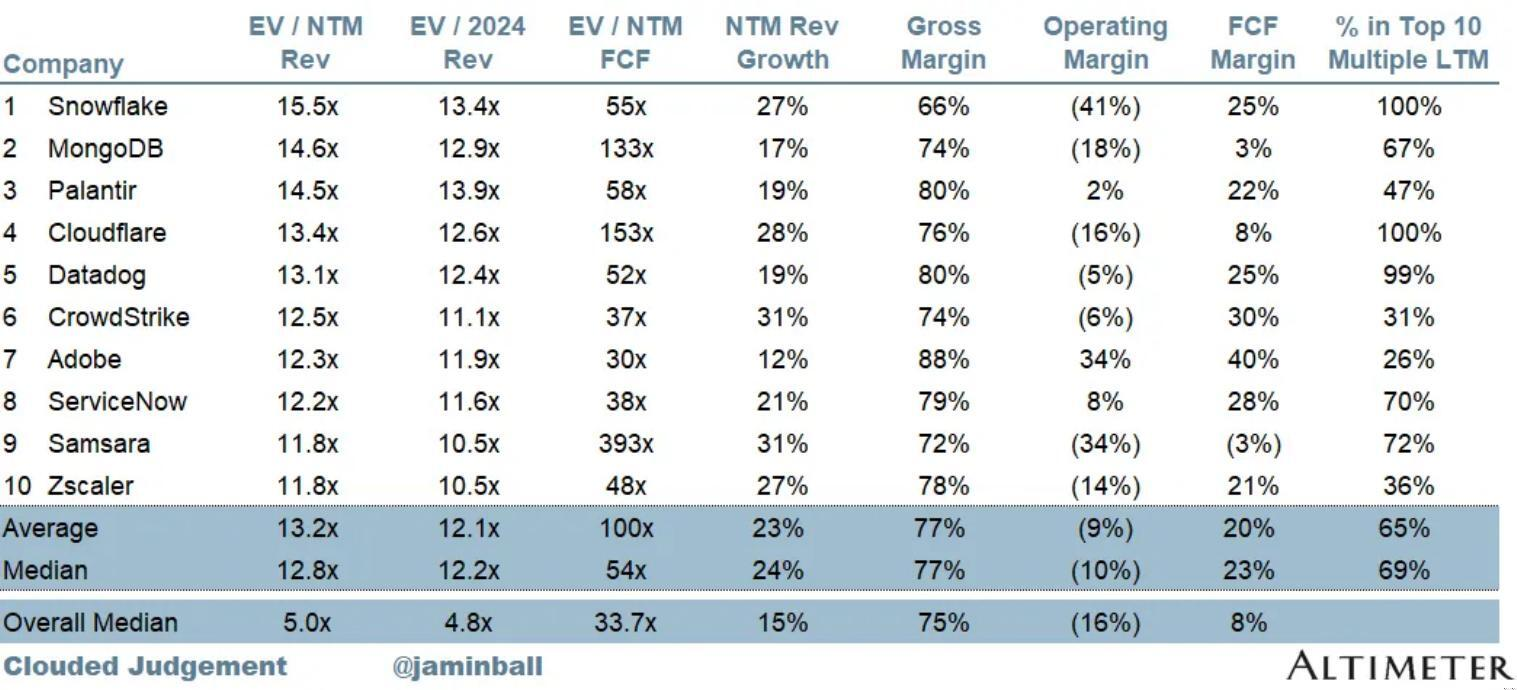

In [21]:
plt_img_base64(img_base64_list[3])

... here is the corresponding summary, which we embedded and used in similarity search.

It's pretty reasonable that this image is indeed retrieved from our `query` based on it's similarity to this summary.

In [22]:
image_summaries[3]

'Financial performance table comparing ten tech companies on various metrics: EV/NTM Revenue, EV/2024 Revenue, EV/NTM FCF, NTM Revenue Growth, Gross Margin, Operating Margin, FCF Margin, and % in Top 10 Multiple LTM. Features companies like Snowflake, MongoDB, and Adobe, along with averages and medians. Created by Altimeter.'

### **RAG**

Now let's run RAG and test the ability to synthesize an answer to our question.

In [23]:
query

'What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?'

In [24]:
# Run RAG chain
print(chain_multimodal_rag.invoke(query))

Based on the provided table:

- **MongoDB:**
  - EV / NTM Rev: 14.6x
  - NTM Rev Growth: 17%

- **Cloudflare:**
  - EV / NTM Rev: 13.4x
  - NTM Rev Growth: 28%

- **Datadog:**
  - EV / NTM Rev: 13.1x
  - NTM Rev Growth: 19%

Regarding the correlation between growth and valuation multiple, the scatter plot shows a positive correlation, as indicated by the trend line. The R-squared value of 0.3821 suggests a moderate correlation, meaning that while growth is a factor in determining valuation multiples, other factors also play a significant role.


Here is the trace where we can see what is passed to the LLM:

* Question 1 [Trace focused on investment advice](https://smith.langchain.com/public/d77b7b52-4128-4772-82a7-c56eb97e8b97/r)
* Question 2 [Trace focused on table extraction](https://smith.langchain.com/public/4624f086-1bd7-4284-9ca9-52fd7e7a4568/r)

For question 1, we can see that we pass 3 images along with a text chunk:

### **Considerations**

**Retrieval**

* Retrieval is performed based upon similarity to image summaries as well as text chunks.
* This requires some careful consideration because image retrieval can fail if there are competing text chunks.
* To mitigate this, I produce larger (4k token) text chunks and summarize them for retrieval.

**Image Size**

* The quality of answer synthesis appears to be sensitive to image size, [as expected](https://platform.openai.com/docs/guides/vision).
* I'll do evals soon to test this more carefully.

## **Conclusion**

By integrating both text and image data using a multimodal LLM, our Multi-modal RAG system can provide richer, more comprehensive information retrieval and synthesis. This approach leverages cutting-edge LLM capabilities and seamlessly incorporates document storage and retrieval using Google Drive.